In [1]:
"""
Comms description:
To investigate if the channel estimation with RCAN itself has strong resistance against location diversity. The location resolution is -1:0.05:1 with velocity of 0.

Net description:
RCAN only

Data description:
Training data is inlcudes raw channel estimation from 1-symbo DMRS and perfect channel estimation with known channel
Data is store at: share/Wenliang/Data Sets/SuperRes ChanEst/SISO1x1 w Diversity/TrainingSet V1/Ant1_RxPos1_RxVel1_SysModOrder1_RawCe_PilotOnly-1
                  Ant1_RxPos1_RxVel1_SysModOrder1_Rx_PerfectCeDataPilotComb_fxt--1.mat

Module and results stored at:work/SuperResolutionChanEst/SISO/Pytorch Files/Diverse Scenario/RCAN with Location/SuperResChanEst-RCAN-20200310-(LocDiv)/             
"""
print('Description')

Description


## MAML dataset reading method

In [2]:
import os

import torch
import numpy as np
import scipy.io as scio
from torch.utils.data import Dataset, DataLoader
import random

class dataset(Dataset):
    def __init__(self, input_path, target_path, mode = 'train', seedNN = 0):
        super(dataset, self).__init__()
        self.input_data = []
        self.target_data = []
        for i_path in input_path:
            i_data = scio.loadmat(i_path)['tmpData']
            self.input_data.append(i_data)
        for t_path in target_path:
            self.target_data.append(scio.loadmat(t_path)['tmpData'])
        self.input_data = np.concatenate(self.input_data, axis=0)
        self.target_data = np.concatenate(self.target_data, axis=0)
        self.length = self.target_data.shape[0]
        
        # 随机打乱顺序
        random.seed(seedNN)
        ind_shuffle = random.sample(range(0, self.length), self.length)

        if mode == 'train':
            self.target_data = self.target_data[ind_shuffle]
            self.input_data = self.input_data[ind_shuffle]
        else:
            self.target_data = self.target_data[ind_shuffle]
            self.input_data = self.input_data[ind_shuffle]
        self.length = self.target_data.shape[0]
#         print(self.input_data.shape)
#         print(self.target_data.shape)
        
    def __getitem__(self, index):
        input_data = torch.from_numpy(self.input_data[index])[:, :, 0].unsqueeze(2)
        target_data = torch.from_numpy(self.target_data[index])
        return input_data, target_data
        
    def __len__(self):
        return self.length

trainfolder='/datadisk/sdc/wangruibo/share1/QWL_DataBase/SuperRes_ChanEst/SISO_1x1/Diversity_LocationVelocity/'
testfolder='/datadisk/sdc/wangruibo/share1/QWL_DataBase/SuperRes_ChanEst/SISO_1x1/Diversity_LocationVelocity/'

class ChanEstDataset(Dataset):
    def __init__(self,trainFolder=trainfolder,testFolder=testfolder,n_batch=64):
       # number of tasks
        self.length=0
        self.traindataloader_Loc={}
        self.testdataloader_Loc={}
        self.LocPatchIndex=['A', 'B', 'C', 'D']
        self.LocationList=range(1, 442)
        self.VelocityList=range(1, 2)    
        self.TrainDataFolder=trainFolder
        self.TestDataFolder=testFolder
        self.load(n_batch)
        
        
    def load(self,n_batch):
        print('Train Data Folder: ',self.TrainDataFolder)
        for il in self.LocPatchIndex:
            input_path11 = [self.TrainDataFolder +'210421_TrainData_NLOS1Square/Loc ' + il + '/RawCe_PilotOnly/10ReDmrs_Ant1_RxPos{}_RxVel{}_ModOrd1_RawCe_PilotOnly-1.mat'.format(i, j) for i in self.LocationList for j in self.VelocityList]
            target_path1 = [self.TrainDataFolder + '210421_TrainData_NLOS1Square/Loc ' + il + '/Rx_PerfectCeDataPilotComb_fxt/10ReDmrs_Ant1_RxPos{}_RxVel{}_ModOrd1_Rx_PerfectCeDataPilotComb_fxt-1.mat'.format(i,j) for i in self.LocationList for j in self.VelocityList]
#             print(il,' ',len(input_path11))
#             print(len(target_path1))
            trainset= dataset(input_path11, target_path1, mode='train', seedNN = 0)
            
            self.length+=trainset.length
            self.traindataloader_Loc[il]= trainset
            
#             self.TestDataFolder
            input_path21 = [self.TrainDataFolder + '210421_TrainData_NLOS1Square/Loc ' + il + '/RawCe_PilotOnly Plus/10ReDmrs_Ant1_RxPos{}_RxVel{}_ModOrd1_RawCe_PilotOnly-1.mat'.format(i, j) for i in self.LocationList for j in self.VelocityList]
            target_path2 = [self.TrainDataFolder + '210421_TrainData_NLOS1Square/Loc ' + il + '/Rx_PerfectCeDataPilotComb_fxt Plus/10ReDmrs_Ant1_RxPos{}_RxVel{}_ModOrd1_Rx_PerfectCeDataPilotComb_fxt-1.mat'.format(i,j) for i in self.LocationList for j in self.VelocityList]
            testset    = dataset(input_path21, target_path2, mode='test', seedNN = 0)
            self.testdataloader_Loc[il]= testset
            
    def sample_task(self, mode='train'):
        return np.random.choice(self.LocPatchIndex)
    def sample_datas(self, name, K = 10, mode='train'):
        data=[]
        label=[]
        if mode == 'train':
            tidx=np.random.choice(range(len(self.traindataloader_Loc[name])),K)
            for i in tidx:
                data.append(self.traindataloader_Loc[name][i][0])
                label.append(self.traindataloader_Loc[name][i][1])
        else:
            tidx=np.random.choice(range(len(self.testdataloader_Loc[name][0])),K)
#             datas=self.testdataloader_Loc[name][0]
#             labels=self.testdataloader_Loc[name][1]
            for i in tidx:
                data.append(self.testdataloader_Loc[name][i][0])
                label.append(self.testdataloader_Loc[name][i][1])
        return data,label
    
    def __len__(self):
        return self.length


In [3]:
maml_data = ChanEstDataset()

Train Data Folder:  /datadisk/sdc/wangruibo/share1/QWL_DataBase/SuperRes_ChanEst/SISO_1x1/Diversity_LocationVelocity/


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import scipy.io as scio
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import time
import matplotlib
import matplotlib.pyplot as plt
# from collections import OrderedDict

## MAML original

In [5]:
class ChannelAttention(nn.Module):
    def __init__(self, num_features, reduction):
        super(ChannelAttention, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.conv1 = nn.Conv2d(num_features, num_features // reduction, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_features // reduction, num_features, kernel_size=1)
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        res = x
        x = self.avgpool(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.sig(x)
        return res * x
    def parameter(self,x,weight):
        res = x
        x = F.adaptive_avg_pool2d(x,(1, 1))
        x = F.conv2d(x,weight[0],weight[1])
        x = F.relu(x)
        x = F.conv2d(x,weight[2],weight[3])
        x = torch.sigmoid(x)
        return res*x

class RCAB(nn.Module):
    def __init__(self, num_features, reduction):
        super(RCAB, self).__init__()
        self.num_features = num_features
        self.reduction = reduction
        self.conv1 = nn.Conv2d(num_features, num_features, kernel_size=(3,1), padding=(1,0))
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_features, num_features, kernel_size=(3,1), padding=(1,0))
        self.cn = ChannelAttention(num_features, reduction)
        
    def forward(self, x):
        res = x
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.cn(x)
        return res + x
    def parameter(self,x,weight):
        res = x
        x = F.conv2d(x,weight[0],weight[1], padding=(1,0))
        x = F.relu(x)
        x = F.conv2d(x,weight[2],weight[3], padding=(1,0))
        cn = ChannelAttention(self.num_features, self.reduction)
        x = cn.parameter(x,weight[4:])
        return res + x
    
class RG(nn.Module):
    def __init__(self, num_features, num_rcab, reduction):
        super(RG, self).__init__()
        self.num_features = num_features
        self.reduction = reduction
        self.module = [RCAB(num_features, reduction) for _ in range(num_rcab)]
        self.module.append(nn.Conv2d(num_features, num_features, kernel_size=(3,1),padding=(1,0)))
        self.module = nn.Sequential(*self.module)
        
    def forward(self, x):
        return x + self.module(x)
#     def parameter(self,x,weight):
    def parameter(self,x,weight):
        res = x
        x = RCAB(self.num_features, self.reduction).parameter(x,weight[:8])
        x = RCAB(self.num_features, self.reduction).parameter(x,weight[8:16])
        x = RCAB(self.num_features, self.reduction).parameter(x,weight[16:24])
        x = RCAB(self.num_features, self.reduction).parameter(x,weight[24:32])
        x = RCAB(self.num_features, self.reduction).parameter(x,weight[32:40])
        x = RCAB(self.num_features, self.reduction).parameter(x,weight[40:48])
        x = F.conv2d(x,weight[48],weight[49],padding=(1,0))
        return res + x

class RCAN(nn.Module):
    def __init__(self, num_features, num_rg, num_rcab, reduction):
        super(RCAN, self).__init__()
        # 64*2*22*1
        self.num_features = num_features
        self.num_rg = num_rg
        self.num_rcab = num_rcab
        self.reduction = reduction
        self.sf = nn.Conv2d(2, num_features, kernel_size=(3,1), padding=(1,0))
        # 64*32*22*1
        self.rgs = nn.Sequential(*[RG(num_features, num_rcab, reduction) for _ in range(num_rg)])
        # 64*32*22*1
        self.conv1 = nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)
        # 64*32*22*1
        self.Tran = nn.Conv2d(num_features, num_features, kernel_size=3, padding=(0,1))
        # 64*32*20*1
        self.Trelu = nn.ReLU()
        self.upscale1 = nn.Conv2d(num_features, num_features*6, kernel_size=3, padding=1)
        # reshape之后变为64*32*60*2
        self.relu1 = nn.ReLU()
        self.upscale2 = nn.Conv2d(num_features, num_features*10, kernel_size=3, padding=1)
        # reshape之后变为64*32*120*10
        self.relu2 = nn.ReLU()
        self.upscale3 = nn.Conv2d(num_features, num_features*10, kernel_size=3, padding=1)
        # reshape之后变为64*32*240*50
        self.relu3 = nn.ReLU()
        self.conv2 = nn.Conv2d(num_features, 2, kernel_size=3, padding=(0,1))
        # 64*2*238*50
        # self.relu4 = nn.ReLU()
        # self.conv3 = nn.Conv2d(num_features, 2, kernel_size=3, padding=1)
        self.num_features = num_features
        
    def forward(self, x):
        x = self.sf(x)
        residual = x
        x = self.rgs(x)
        x = self.conv1(x)
        x += residual
        x = self.Trelu(self.Tran(x))
        x = self.upscale1(x)
        # 类似于nn.PixelShuffle
        x = x.view(x.shape[0], self.num_features, 60, 2)
        x = self.relu1(x)
        x = self.upscale2(x)
        x = x.view(x.shape[0], self.num_features, 120, 10)
        x = self.relu2(x)
        x = self.upscale3(x)
        x = x.view(x.shape[0], self.num_features, 240, 50)
        x = self.relu3(x)
        x = self.conv2(x)
        # x = self.relu4(x)
        # x = self.conv3(x)
        return x
    def parameter(self,x,weight):
        x = F.conv2d(x,weight[0],weight[1],padding=(1,0))
        residual = x
        x = RG(self.num_features, self.num_rcab, self.reduction).parameter(x,weight[2:52])
        x = RG(self.num_features, self.num_rcab, self.reduction).parameter(x,weight[52:102])
        x = RG(self.num_features, self.num_rcab, self.reduction).parameter(x,weight[102:152])
        x = F.conv2d(x,weight[152],weight[153],padding=1)
        x += residual
        x = F.relu(F.conv2d(x,weight[154],weight[155], padding=(0,1)))
        x = F.conv2d(x,weight[156],weight[157], padding=1)
        # 类似于nn.PixelShuffle
        x = x.view(x.shape[0], self.num_features, 60, 2)
        x = F.relu(x)
        x = F.conv2d(x,weight[158],weight[159], padding=1)
        x = x.view(x.shape[0], self.num_features, 120, 10)
        x = F.relu(x)
        x = F.conv2d(x,weight[160],weight[161], padding=1)
        x = x.view(x.shape[0], self.num_features, 240, 50)
        x = F.relu(x)
        x = F.conv2d(x,weight[162],weight[163], padding=(0,1))
        # x = self.relu4(x)
        # x = self.conv3(x)
        return x

In [6]:
import time
class MAML():
    def __init__(self, model, tasks, inner_lr, meta_lr, K=10, inner_steps=1, tasks_per_meta_batch=10):
        
        # important objects
        self.tasks = tasks
        self.model = model
        self.weights = list(model.parameters()) # the maml weights we will be meta-optimising
        self.criterion = nn.MSELoss()
        self.meta_optimiser = torch.optim.Adam(self.weights, meta_lr)
        
        # hyperparameters
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr
        self.K = K
        self.inner_steps = inner_steps # with the current design of MAML, >1 is unlikely to work well 
        self.tasks_per_meta_batch = tasks_per_meta_batch 
        self.scheduler = optim.lr_scheduler.StepLR(self.meta_optimiser, step_size=10, gamma=0.9)
        # metrics
        self.plot_every = 100
        self.print_every = 500
        self.meta_losses = []
    
    def inner_loop(self, task):
        # reset inner model to current maml weights
        temp_weights = [w.clone() for w in self.weights]
        
        # perform training on data sampled from task
        X, y = self.tasks.sample_datas(task, self.K)
        X = torch.stack(X).float().cuda()
        y = torch.stack(y).float().cuda()
        for step in range(self.inner_steps):
            loss = self.criterion(self.model.parameter(X,temp_weights), y) / self.K
            
            # compute grad and update inner loop weights
            grad = torch.autograd.grad(loss, temp_weights)
            temp_weights = [w - self.inner_lr * g for w, g in zip(temp_weights, grad)]
        
        # sample new data for meta-update and compute loss
        X, y = self.tasks.sample_datas(task, self.K)
        X = torch.stack(X).float().cuda()
        y = torch.stack(y).float().cuda()
#         loss = self.criterion(self.model.parameterised(X,s, temp_weights), y) / self.K
        loss = self.criterion(self.model.parameter(X,temp_weights), y) / self.K
        return loss
    
    def main_loop(self, num_iterations):
        epoch_loss = 0
        
        for iteration in range(1, num_iterations+1):
            time_start = time.time()
            # compute meta loss
            meta_loss = 0
            for i in range(self.tasks_per_meta_batch):
                task = self.tasks.sample_task()
                meta_loss += self.inner_loop(task)
            
            # compute meta gradient of loss with respect to maml weights
            meta_grads = torch.autograd.grad(meta_loss, self.weights)
            
            # assign meta gradient to weights and take optimisation step
            for w, g in zip(self.weights, meta_grads):
                w.grad = g
            self.meta_optimiser.step()
            self.scheduler.step()
            time_end = time.time()
            # log metrics
            epoch_loss += meta_loss.item() / self.tasks_per_meta_batch
            showStrings = '[Epoch: %3d/%3d][Epoch loss: %3.5f][CostTime: %3.5f s]' % (iteration,  num_iterations, epoch_loss,time_end -time_start)
            print(showStrings)
            epoch_loss = 0

In [7]:
maml_model = RCAN(32, 3, 6, 8).cuda()

In [8]:
maml_task = MAML(maml_model.cuda(),maml_data,inner_lr = 0.001,meta_lr = 0.001, K=10, inner_steps=1, tasks_per_meta_batch=50)

In [9]:
maml_task.main_loop(200)

[Epoch:   1/200][Epoch loss: 0.03843][CostTime: 7.47023 s]
[Epoch:   2/200][Epoch loss: 0.04670][CostTime: 6.98798 s]
[Epoch:   3/200][Epoch loss: 0.04450][CostTime: 6.79402 s]
[Epoch:   4/200][Epoch loss: 0.04743][CostTime: 6.77844 s]
[Epoch:   5/200][Epoch loss: 0.04245][CostTime: 6.67894 s]
[Epoch:   6/200][Epoch loss: 0.04015][CostTime: 6.67839 s]
[Epoch:   7/200][Epoch loss: 0.04971][CostTime: 6.70137 s]
[Epoch:   8/200][Epoch loss: 0.04409][CostTime: 6.61726 s]
[Epoch:   9/200][Epoch loss: 0.03900][CostTime: 7.04876 s]
[Epoch:  10/200][Epoch loss: 0.04257][CostTime: 7.00552 s]
[Epoch:  11/200][Epoch loss: 0.03437][CostTime: 6.88076 s]
[Epoch:  12/200][Epoch loss: 0.03270][CostTime: 6.98408 s]
[Epoch:  13/200][Epoch loss: 0.03025][CostTime: 7.10875 s]
[Epoch:  14/200][Epoch loss: 0.03617][CostTime: 6.82740 s]
[Epoch:  15/200][Epoch loss: 0.03543][CostTime: 6.53550 s]
[Epoch:  16/200][Epoch loss: 0.03872][CostTime: 6.80623 s]
[Epoch:  17/200][Epoch loss: 0.03062][CostTime: 6.59765 

In [11]:
torch.save(maml_task.model.state_dict(), '/datadisk/sdc/wangruibo/Code_MAML_newframework/PyTorch-MAML-master/MAML_LOCATIONAL/New_dict/'+ 'Checkpoints.pth')

In [76]:
import torch.optim as optim
import time
def joint_traninig(net,Epoch,dataset,SaveFolder,savename,K,evaluation=True,save_num = 500,inner_loop = 50):
    
    # Construct NN and parameters
#     net = SubCAN(32, 3, 6, 8).cuda()
    NetworkParamNum = "Total number of paramerters in networks is {}  ".format(sum(x.numel() for x in net.parameters()))
    print(NetworkParamNum)
    
    # Construct scheduler
    lr = 0.001
    # criterion = nn.L1Loss()
    # optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=10**(-5))
    optimizer = optim.Adam(net.parameters(), lr=lr)
#     scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    criterion = nn.MSELoss()
    # Initialize some parameters
    min_testloss = 100
    testError  = []
    trainError = []
    costTime   = []
    BER_train = []
    BER_test = []
    KL_train = []
    KL_test = []
    storeStepResult = True
    minloss = 1000000000
    
    for epoch in range(Epoch):
        net.train()
        train_loss = 0.0
        test_loss  = 0.0      
        numTrain = 0
        numTest  = 0 
        bertrain = 0
        bertest = 0
        time_start = time.time()
        
        for i in range(1,inner_loop):
            optimizer.zero_grad()
            task = dataset.sample_task()
            X, y = dataset.sample_datas(task, K)
            X = torch.stack(X).float().cuda()
            y = torch.stack(y).float().cuda()

            t_pred = net(X)
            loss = criterion(t_pred,y)
                            # loss = criterion(t_pred, target)
            loss.backward()
            optimizer.step()
            train_loss += float(loss.item())
#         scheduler.step()
            
        scheduler.step()
        numTrain = 50
                    
            # 测试
        if evaluation:
            net.eval()
            task = dataset.sample_task()
            X, y = dataset.sample_datas(task, K)
            X = torch.stack(X).float().cuda()
            y = torch.stack(y).float().cuda()
            loss = criterion(t_pred,y)
#                 KL = KL(t_pred,target)
                        # loss = criterion(t_pred, target)
            test_loss += float(loss.item())
            numTest = 50
        
        time_end = time.time()
        
        train_loss /= numTrain
#         train_loss /= torch.log(torch.tensor([2.]))
#         train_loss = torch.mean(torch.tensor(4.)-torch.sum(train_loss,axis = 3))
        if evaluation:
            test_loss  /= numTest
            
#         test_loss /= torch.log(torch.tensor([2.]))
        # For print and record Loss
        cost = time_end - time_start
        if evaluation:
            showStrings = '[Epoch: %3d/%3d][train loss:%3.5f][test loss:%3.5f][CostTime: %3.5f s]' % (epoch+1, Epoch, train_loss,test_loss, cost)
        else:
            showStrings = '[Epoch: %3d/%3d][train loss:%3.5f][CostTime: %3.5f s]' % (epoch+1, Epoch, train_loss, cost)
        print(showStrings, end='\n')
        name = 'Joint' + savename
        trainError.append(train_loss)
        testError.append(test_loss)
        costTime.append(cost)
        BER_train.append(bertrain)
        BER_test.append(bertest)
        file = open(SaveFolder + name + '.txt' , 'w')
        file.write(NetworkParamNum + "\n")
        file.write('TrainingLoss = ' + str(trainError) + "\n")
        file.write('TestingLoss = '  + str(testError) + "\n")
        file.write('CostTime Epoch (s): ' + str(costTime) + "\n")
        file.close()
#         if epoch % save_num == 0:
#             torch.save(net.state_dict(),  SaveFolder+ 'Checkpoints-Epk{}.pth'.format(epoch))
        torch.save(net.state_dict(),  SaveFolder+ 'Checkpoints-Epk{}.pth'.format(epoch))

In [78]:
joint_model = RCAN(32, 3, 6, 8).cuda()
save_name = '_joint_one'
joint_traninig(joint_model,200,maml_data,'/datadisk/sdc/wangruibo/Code_MAML_newframework/PyTorch-MAML-master/MAML_LOCATIONAL/New_dict_joint/',save_name,10)

Total number of paramerters in networks is 386058  
[Epoch:   1/200][train loss:0.34782][test loss:0.02202][CostTime: 2.45783 s]
[Epoch:   2/200][train loss:0.24586][test loss:0.02446][CostTime: 2.28341 s]
[Epoch:   3/200][train loss:0.23740][test loss:0.00963][CostTime: 2.28477 s]
[Epoch:   4/200][train loss:0.10740][test loss:0.02196][CostTime: 2.23609 s]
[Epoch:   5/200][train loss:0.03053][test loss:0.01467][CostTime: 2.20599 s]
[Epoch:   6/200][train loss:0.02535][test loss:0.01267][CostTime: 2.23403 s]
[Epoch:   7/200][train loss:0.02731][test loss:0.03709][CostTime: 2.37511 s]
[Epoch:   8/200][train loss:0.02621][test loss:0.01551][CostTime: 2.29019 s]
[Epoch:   9/200][train loss:0.02528][test loss:0.01006][CostTime: 2.36017 s]
[Epoch:  10/200][train loss:0.02396][test loss:0.00588][CostTime: 2.18273 s]
[Epoch:  11/200][train loss:0.02643][test loss:0.01858][CostTime: 2.21996 s]
[Epoch:  12/200][train loss:0.02306][test loss:0.00925][CostTime: 2.22642 s]
[Epoch:  13/200][train l

In [100]:
import torch.optim as optim
import time
def joint_traninig(net,Epoch,dataset,SaveFolder,savename,K,evaluation=True,save_num = 500,inner_loop = 50):
    
    # Construct NN and parameters
#     net = SubCAN(32, 3, 6, 8).cuda()
    NetworkParamNum = "Total number of paramerters in networks is {}  ".format(sum(x.numel() for x in net.parameters()))
    print(NetworkParamNum)
    
    # Construct scheduler
    lr = 0.001
    # criterion = nn.L1Loss()
    # optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=10**(-5))
    optimizer = optim.Adam(net.parameters(), lr=lr)
#     scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    criterion = nn.MSELoss()
    # Initialize some parameters
    min_testloss = 100
    testError  = []
    trainError = []
    costTime   = []
    BER_train = []
    BER_test = []
    KL_train = []
    KL_test = []
    storeStepResult = True
    minloss = 1000000000
    
    for epoch in range(Epoch):
        net.train()
        train_loss = 0.0
        test_loss  = 0.0      
        numTrain = 0
        numTest  = 0 
        bertrain = 0
        bertest = 0
        time_start = time.time()
        optimizer.zero_grad()
        task = dataset.sample_task()
        X, y = dataset.sample_datas(task, K)
        X = torch.stack(X).float().cuda()
        y = torch.stack(y).float().cuda()

        t_pred = net(X)
        loss = criterion(t_pred,y)
                            # loss = criterion(t_pred, target)
        loss.backward()
        optimizer.step()
        train_loss += float(loss.item())
#         scheduler.step()
            
        scheduler.step()
        numTrain = 1
                    
            # 测试
        if evaluation:
            net.eval()
            task = dataset.sample_task()
            X, y = dataset.sample_datas(task, K)
            X = torch.stack(X).float().cuda()
            y = torch.stack(y).float().cuda()
            loss = criterion(t_pred,y)
#                 KL = KL(t_pred,target)
                        # loss = criterion(t_pred, target)
            test_loss += float(loss.item())
            numTest = 1
        
        time_end = time.time()
        
        train_loss /= numTrain
#         train_loss /= torch.log(torch.tensor([2.]))
#         train_loss = torch.mean(torch.tensor(4.)-torch.sum(train_loss,axis = 3))
        if evaluation:
            test_loss  /= numTest
            
#         test_loss /= torch.log(torch.tensor([2.]))
        # For print and record Loss
        cost = time_end - time_start
        if evaluation:
            showStrings = '[Epoch: %3d/%3d][train loss:%3.5f][test loss:%3.5f][CostTime: %3.5f s]' % (epoch+1, Epoch, train_loss,test_loss, cost)
        else:
            showStrings = '[Epoch: %3d/%3d][train loss:%3.5f][CostTime: %3.5f s]' % (epoch+1, Epoch, train_loss, cost)
        print(showStrings, end='\n')
        name = 'Joint' + savename
        trainError.append(train_loss)
        testError.append(test_loss)
        costTime.append(cost)
        BER_train.append(bertrain)
        BER_test.append(bertest)
        file = open(SaveFolder + name + '.txt' , 'w')
        file.write(NetworkParamNum + "\n")
        file.write('TrainingLoss = ' + str(trainError) + "\n")
        file.write('TestingLoss = '  + str(testError) + "\n")
        file.write('CostTime Epoch (s): ' + str(costTime) + "\n")
        file.close()
#         if epoch % save_num == 0:
#             torch.save(net.state_dict(),  SaveFolder+ 'Checkpoints-Epk{}.pth'.format(epoch))
        torch.save(net.state_dict(),  SaveFolder+ 'Checkpoints-Epk{}.pth'.format(epoch))

In [101]:
joint_model = RCAN(32, 3, 6, 8).cuda()
save_name = '_joint_one'
joint_traninig(joint_model,200,maml_data,'/datadisk/sdc/wangruibo/Code_MAML_newframework/PyTorch-MAML-master/MAML_LOCATIONAL/New_dict_joint_no_loop/',save_name,10)

Total number of paramerters in networks is 386058  
[Epoch:   1/200][train loss:0.84578][test loss:0.83866][CostTime: 0.09388 s]
[Epoch:   2/200][train loss:0.51300][test loss:0.42565][CostTime: 0.06890 s]
[Epoch:   3/200][train loss:0.14452][test loss:0.81567][CostTime: 0.05909 s]
[Epoch:   4/200][train loss:0.40281][test loss:0.75740][CostTime: 0.05622 s]
[Epoch:   5/200][train loss:0.49152][test loss:0.16769][CostTime: 0.05736 s]
[Epoch:   6/200][train loss:0.35499][test loss:0.83362][CostTime: 0.05694 s]
[Epoch:   7/200][train loss:0.16530][test loss:0.49870][CostTime: 0.05562 s]
[Epoch:   8/200][train loss:0.64549][test loss:0.43204][CostTime: 0.05460 s]
[Epoch:   9/200][train loss:0.25436][test loss:0.40772][CostTime: 0.05464 s]
[Epoch:  10/200][train loss:0.37862][test loss:0.34098][CostTime: 0.05511 s]
[Epoch:  11/200][train loss:0.58090][test loss:0.64977][CostTime: 0.05512 s]
[Epoch:  12/200][train loss:0.47177][test loss:0.42212][CostTime: 0.05470 s]
[Epoch:  13/200][train l

In [79]:
TrainingDataFolder = "/datadisk/sdc/wangruibo/share1/QWL_DataBase/SuperRes_ChanEst/SISO_1x1/Diversity_LocationVelocity/210421_TrainData_NLOS1Square/"
TestingDataFolder  = "/datadisk/sdc/wangruibo/share1/QWL_DataBase/SuperRes_ChanEst/SISO_1x1/Diversity_LocationVelocity/210421_TestData_NLOS1Square/"

In [80]:
class dataset(Dataset):
    def __init__(self, input_path, target_path, mode = 'train', seedNN = 0):
        super(dataset, self).__init__()
        self.input_data = []
        self.target_data = []
        for i_path in input_path:
            i_data = scio.loadmat(i_path)['tmpData']
            self.input_data.append(i_data)
        for t_path in target_path:
            self.target_data.append(scio.loadmat(t_path)['tmpData'])
        self.input_data = np.concatenate(self.input_data, axis=0)
        self.target_data = np.concatenate(self.target_data, axis=0)
        self.length = self.target_data.shape[0]
        
        # 随机打乱顺序
        random.seed(seedNN)
        ind_shuffle = random.sample(range(0, self.length), self.length)

        if mode == 'train':
            self.target_data = self.target_data[ind_shuffle]
            self.input_data = self.input_data[ind_shuffle]
        else:
            self.target_data = self.target_data[ind_shuffle]
            self.input_data = self.input_data[ind_shuffle]
        self.length = self.target_data.shape[0]
#         print(self.input_data.shape)
#         print(self.target_data.shape)
        
    def __getitem__(self, index):
        input_data = torch.from_numpy(self.input_data[index])[:, :, 0].unsqueeze(2)
        target_data = torch.from_numpy(self.target_data[index])
        return input_data, target_data
        
    def __len__(self):
        return self.length

In [81]:
# 41 Locations see data description
'''
for splitted data loader
'''
def DataSplitter(LocPatchIndex, LocationList, VelocityList, seedNN = 0):
    input_path11 = [TrainingDataFolder + 'Loc ' + LocPatchIndex + '/RawCe_PilotOnly/10ReDmrs_Ant1_RxPos{}_RxVel{}_ModOrd1_RawCe_PilotOnly-1.mat'.format(i, j) for i in LocationList for j in VelocityList]
    target_path1 = [TrainingDataFolder + 'Loc ' + LocPatchIndex + '/Rx_PerfectCeDataPilotComb_fxt/10ReDmrs_Ant1_RxPos{}_RxVel{}_ModOrd1_Rx_PerfectCeDataPilotComb_fxt-1.mat'.format(i,j) for i in LocationList for j in VelocityList]
    
    input_path21 = [TrainingDataFolder + 'Loc ' + LocPatchIndex + '/RawCe_PilotOnly Plus/10ReDmrs_Ant1_RxPos{}_RxVel{}_ModOrd1_RawCe_PilotOnly-1.mat'.format(i, j) for i in LocationList for j in VelocityList]
    target_path2 = [TrainingDataFolder + 'Loc ' + LocPatchIndex + '/Rx_PerfectCeDataPilotComb_fxt Plus/10ReDmrs_Ant1_RxPos{}_RxVel{}_ModOrd1_Rx_PerfectCeDataPilotComb_fxt-1.mat'.format(i,j) for i in LocationList for j in VelocityList]
    
    trainset    = dataset(input_path11, target_path1, mode='train', seedNN = seedNN)
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)

    testset    = dataset(input_path21, target_path2, mode='test', seedNN = seedNN)
    testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)
    
    return trainloader,testloader

In [140]:
def maml_train_e(Epoch,model,save_path):
    NetworkParamNum = "Total number of paramerters in networks is {}  ".format(sum(x.numel() for x in model.parameters()))
    print(NetworkParamNum)
    
    lr = 0.001
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    min_testloss = 10000
    
    testError  = []
    trainError = []
    costTime   = []
    
    # [1 3 5 7 9 19 21 23 25 27 37 39 41 43 45 55 57 59 61 63 73 75 77 79 81]
    # [1, 5 ,9 ,37 ,41, 45 ,73, 77, 81]
    LocationList = range(1, 2)
    VelocityList = range(1, 2)
    
    LocPatchList = 'A'
    trainloader,testloader = DataSplitter(LocPatchList, LocationList, VelocityList)
    zero_loss_train = 0
    zero_loss_eval = 0
    for dmrs, target in trainloader:
        model.eval()
        target = target.cuda().float()
        dmrs = dmrs.cuda().float()
        t_pred = model(dmrs)
        loss = torch.mean((t_pred - target) ** 2)
        zero_loss_train += loss.item()
    trainError.append(zero_loss_train/len(trainloader))
    for dmrs, target in testloader:
        model.eval()
        target = target.cuda().float()
        dmrs = dmrs.cuda().float()
        t_pred = model(dmrs)
        loss = torch.mean((t_pred - target) ** 2)
        zero_loss_eval += loss.item()
    testError.append(zero_loss_eval/len(testloader))
    showStrings = '[Epoch: %3d/%3d][TraingLoss: %3.5f][TestingLoss:%3.5f]' % (0, Epoch, zero_loss_train/len(trainloader), zero_loss_eval/len(testloader))
    print(showStrings, end='\n')
    for epoch in range(Epoch):
        model.train()
        train_loss = 0.0
        test_loss = 0.
        time_start = time.time()
        numPatchList = len(LocPatchList)

            
        for dmrs, target in trainloader:
                optimizer.zero_grad()
                target = target.cuda().float()
                dmrs = dmrs.cuda().float()
                t_pred = model(dmrs)
                loss = torch.mean((t_pred - target) ** 2)
                loss.backward()
                optimizer.step()
                train_loss += float(loss.item())
        scheduler.step()
        numtr = len(trainloader)
            
        del t_pred, target, dmrs
        
        model.eval()
            
        for dmrs, target in testloader:
                target = target.cuda().float()
                dmrs = dmrs.cuda().float()
                t_pred = model(dmrs)
                loss = torch.mean((t_pred - target) ** 2)
                test_loss += loss.item()
        numte = len(testloader)
            
        del t_pred, target, dmrs
        
        train_loss = train_loss / numtr / numPatchList
        test_loss = test_loss / numte / numPatchList
        
        time_end = time.time()
        cost = time_end - time_start
        showStrings = '[Epoch: %3d/%3d][TraingLoss: %3.5f][TestingLoss:%3.5f][CostTime: %3.5f s]' % (epoch+1, Epoch, train_loss, test_loss, cost)
        
        print(showStrings, end='\n')
        trainError.append(train_loss)
        testError.append(test_loss)
        costTime.append(cost)
        
        file = open(save_path + 'Checkpoints.txt' , 'w')
        file.write(NetworkParamNum + "\n")
        file.write('TrainingLoss = ' + str(trainError) + "\n")
        file.write('TestingLoss = '  + str(testError) + "\n")
        file.write('CostTime Epoch (s): ' + str(costTime) + "\n")
        file.close()
#         if test_loss < min_testloss:
#             min_testloss = test_loss
#         torch.save(net, save_path +'/model/maml-rcan-Epk{}.pth'.format(epoch+1))
#         torch.save(net.state_dict(), save_path +'/dict/maml-rcan-Epk{}.pth'.format(epoch+1))

    return trainError,testError,costTime

In [141]:
maml_fine = RCAN(32, 3, 6, 8).cuda()
maml_fine.load_state_dict(torch.load('/datadisk/sdc/wangruibo/Code_MAML_newframework/PyTorch-MAML-master/MAML_LOCATIONAL/New_dict_maml/Checkpoints.pth'))

trainError_MAML,testError_MAML,costTime_MAML = maml_train_e(20,maml_fine,'/datadisk/sdc/wangruibo/Code_MAML_newframework/PyTorch-MAML-master/MAML_LOCATIONAL/fine_tune_maml_A/')

Total number of paramerters in networks is 386058  


/datadisk/sdc/wangruibo/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch:   0/ 20][TraingLoss: 0.01835][TestingLoss:0.01798]
[Epoch:   1/ 20][TraingLoss: 0.03582][TestingLoss:0.06130][CostTime: 39.15972 s]
[Epoch:   2/ 20][TraingLoss: 0.04440][TestingLoss:0.01022][CostTime: 39.75555 s]
[Epoch:   3/ 20][TraingLoss: 0.02027][TestingLoss:0.01474][CostTime: 39.98089 s]
[Epoch:   4/ 20][TraingLoss: 0.01260][TestingLoss:0.01696][CostTime: 40.38613 s]
[Epoch:   5/ 20][TraingLoss: 0.01676][TestingLoss:0.01082][CostTime: 42.10836 s]
[Epoch:   6/ 20][TraingLoss: 0.00901][TestingLoss:0.01158][CostTime: 41.79602 s]
[Epoch:   7/ 20][TraingLoss: 0.01116][TestingLoss:0.00729][CostTime: 41.02479 s]
[Epoch:   8/ 20][TraingLoss: 0.00743][TestingLoss:0.00939][CostTime: 40.95345 s]
[Epoch:   9/ 20][TraingLoss: 0.00892][TestingLoss:0.00670][CostTime: 41.11227 s]
[Epoch:  10/ 20][TraingLoss: 0.00652][TestingLoss:0.00754][CostTime: 40.28821 s]
[Epoch:  11/ 20][TraingLoss: 0.00728][TestingLoss:0.00614][CostTime: 40.80575 s]
[Epoch:  12/ 20][TraingLoss: 0.00603][TestingLoss:

In [142]:
joint_fine = RCAN(32, 3, 6, 8).cuda()
joint_fine.load_state_dict(torch.load('/datadisk/sdc/wangruibo/Code_MAML_newframework/PyTorch-MAML-master/MAML_LOCATIONAL/New_dict_joint/Checkpoints-Epk199.pth'))

trainError_MAML,testError_MAML,costTime_MAML = maml_train_e(20,joint_fine,'/datadisk/sdc/wangruibo/Code_MAML_newframework/PyTorch-MAML-master/MAML_LOCATIONAL/fine_tune_joint_A/')

Total number of paramerters in networks is 386058  
[Epoch:   0/ 20][TraingLoss: 0.00437][TestingLoss:0.00400]
[Epoch:   1/ 20][TraingLoss: 0.01255][TestingLoss:0.00741][CostTime: 42.82571 s]
[Epoch:   2/ 20][TraingLoss: 0.00670][TestingLoss:0.00360][CostTime: 39.93442 s]
[Epoch:   3/ 20][TraingLoss: 0.00464][TestingLoss:0.00342][CostTime: 40.24825 s]
[Epoch:   4/ 20][TraingLoss: 0.00369][TestingLoss:0.00238][CostTime: 41.34253 s]
[Epoch:   5/ 20][TraingLoss: 0.00272][TestingLoss:0.00261][CostTime: 41.27813 s]
[Epoch:   6/ 20][TraingLoss: 0.00211][TestingLoss:0.00195][CostTime: 40.92311 s]
[Epoch:   7/ 20][TraingLoss: 0.00187][TestingLoss:0.00144][CostTime: 41.06787 s]
[Epoch:   8/ 20][TraingLoss: 0.00166][TestingLoss:0.00130][CostTime: 41.16107 s]
[Epoch:   9/ 20][TraingLoss: 0.00134][TestingLoss:0.00139][CostTime: 39.92540 s]
[Epoch:  10/ 20][TraingLoss: 0.00121][TestingLoss:0.00104][CostTime: 40.85072 s]
[Epoch:  11/ 20][TraingLoss: 0.00108][TestingLoss:0.00090][CostTime: 40.81838 s

In [143]:
joint_fine = RCAN(32, 3, 6, 8).cuda()
trainError_MAML,testError_MAML,costTime_MAML = maml_train_e(20,joint_fine,'/datadisk/sdc/wangruibo/Code_MAML_newframework/PyTorch-MAML-master/MAML_LOCATIONAL/scratch_A/')

Total number of paramerters in networks is 386058  
[Epoch:   0/ 20][TraingLoss: 0.30546][TestingLoss:0.30546]
[Epoch:   1/ 20][TraingLoss: 0.29377][TestingLoss:0.25576][CostTime: 40.00428 s]
[Epoch:   2/ 20][TraingLoss: 0.18836][TestingLoss:0.03760][CostTime: 42.43074 s]
[Epoch:   3/ 20][TraingLoss: 0.04661][TestingLoss:0.03210][CostTime: 40.57689 s]
[Epoch:   4/ 20][TraingLoss: 0.04309][TestingLoss:0.03312][CostTime: 42.73663 s]
[Epoch:   5/ 20][TraingLoss: 0.02239][TestingLoss:0.03517][CostTime: 41.04133 s]
[Epoch:   6/ 20][TraingLoss: 0.02455][TestingLoss:0.01118][CostTime: 40.42979 s]
[Epoch:   7/ 20][TraingLoss: 0.01540][TestingLoss:0.01603][CostTime: 41.63371 s]
[Epoch:   8/ 20][TraingLoss: 0.01182][TestingLoss:0.01039][CostTime: 38.73674 s]
[Epoch:   9/ 20][TraingLoss: 0.01218][TestingLoss:0.00818][CostTime: 42.05310 s]
[Epoch:  10/ 20][TraingLoss: 0.00772][TestingLoss:0.00936][CostTime: 39.74992 s]
[Epoch:  11/ 20][TraingLoss: 0.00879][TestingLoss:0.00634][CostTime: 42.58099 s

In [144]:
joint_fine_no = RCAN(32, 3, 6, 8).cuda()
joint_fine_no.load_state_dict(torch.load('/datadisk/sdc/wangruibo/Code_MAML_newframework/PyTorch-MAML-master/MAML_LOCATIONAL/New_dict_joint_no_loop/Checkpoints-Epk199.pth'))
trainError_MAML,testError_MAML,costTime_MAML = maml_train_e(20,joint_fine_no,'/datadisk/sdc/wangruibo/Code_MAML_newframework/PyTorch-MAML-master/MAML_LOCATIONAL/fine_tune_joint_no_loop_A/')

Total number of paramerters in networks is 386058  
[Epoch:   0/ 20][TraingLoss: 0.01858][TestingLoss:0.01827]
[Epoch:   1/ 20][TraingLoss: 0.02798][TestingLoss:0.01957][CostTime: 43.68281 s]
[Epoch:   2/ 20][TraingLoss: 0.01570][TestingLoss:0.01479][CostTime: 42.39937 s]
[Epoch:   3/ 20][TraingLoss: 0.01024][TestingLoss:0.00969][CostTime: 41.00865 s]
[Epoch:   4/ 20][TraingLoss: 0.00840][TestingLoss:0.00790][CostTime: 39.77033 s]
[Epoch:   5/ 20][TraingLoss: 0.00830][TestingLoss:0.00623][CostTime: 41.06571 s]
[Epoch:   6/ 20][TraingLoss: 0.00657][TestingLoss:0.00666][CostTime: 41.63982 s]
[Epoch:   7/ 20][TraingLoss: 0.00618][TestingLoss:0.00602][CostTime: 41.16020 s]
[Epoch:   8/ 20][TraingLoss: 0.00582][TestingLoss:0.00491][CostTime: 41.31996 s]
[Epoch:   9/ 20][TraingLoss: 0.00511][TestingLoss:0.00483][CostTime: 39.52102 s]
[Epoch:  10/ 20][TraingLoss: 0.00482][TestingLoss:0.00468][CostTime: 42.45360 s]
[Epoch:  11/ 20][TraingLoss: 0.00459][TestingLoss:0.00426][CostTime: 39.39109 s

## Result

In [28]:
scratch_TrainingLoss = [0.670957088470459, 0.648954431215922, 0.5092921952406565, 0.1443498656153679, 0.05553317815065384, 0.0458050270875295, 0.04677360753218333, 0.030176253989338875, 0.022014227385322254, 0.022766285265485447, 0.01594386932750543, 0.017194839815298717, 0.01478800488015016, 0.012916219420731068, 0.01326375020047029, 0.011238080759843191, 0.011504569090902805, 0.010846528224647045, 0.010337169903020063, 0.010154528232912222, 0.009561958101888498]
scratch_TestingLoss = [0.6709566116333008, 0.5908997654914856, 0.19894039630889893, 0.029743419960141182, 0.07248424738645554, 0.04926418885588646, 0.022997479885816574, 0.031585872173309326, 0.01957288198173046, 0.014041299931704998, 0.020454930141568184, 0.012391992844641209, 0.013959143310785294, 0.013178083114326, 0.011428508907556534, 0.011615635827183723, 0.010277889668941498, 0.010763289406895638, 0.009860368445515633, 0.009296627715229988, 0.009444141760468483]

In [29]:
joint_TrainingLoss = [0.004762931726872921, 0.010627820622175932, 0.008141285041347146, 0.005055151181295514, 0.0032594375467548766, 0.0022517507895827293, 0.002220276238707205, 0.0019921096973121166, 0.0013751554070040584, 0.0015534040285274386, 0.0011868919633949797, 0.0010976148769259453, 0.0011040726288532217, 0.0009937046561390162, 0.0008963642758317292, 0.0008721092793469628, 0.0008333202761908373, 0.000776426886053135, 0.0007467104975755016, 0.0006780451318869988, 0.000634677455915759]
joint_TestingLoss = [0.004108073189854622, 0.0134694529697299, 0.006565913558006287, 0.0025783744640648365, 0.0021143723279237747, 0.002560431370511651, 0.0014285894576460123, 0.0011747460812330246, 0.0015326017746701837, 0.0010370733216404915, 0.0009523299522697926, 0.001100545865483582, 0.0008513842476531863, 0.0008667359361425042, 0.0010152823524549603, 0.0008330696728080511, 0.000840486609376967, 0.0008011900936253369, 0.0007564491825178266, 0.0007584392442367971, 0.0006933776894584298]

In [30]:
joint_no_TrainingLoss = [0.028453368693590164, 0.467115701486667, 0.2652946213881175, 0.3891623119513194, 0.3443501492341359, 0.24852957328160605, 0.15258625149726868, 0.07676153133312862, 0.0243665874004364, 0.02327415222922961, 0.03326410303513209, 0.027240193759401638, 0.019579829027255375, 0.014859899257620176, 0.014166967322429022, 0.01385707159837087, 0.013943447110553583, 0.013398798493047556, 0.01264561495433251, 0.011681778356432915, 0.011208612782259783]
joint_no_TestingLoss = [0.028314145281910896, 0.13698019087314606, 0.39717134833335876, 0.36731040477752686, 0.28838691115379333, 0.17763346433639526, 0.10451614111661911, 0.031288329511880875, 0.019789280369877815, 0.030892280861735344, 0.029610497877001762, 0.021448686718940735, 0.015721721574664116, 0.013673159293830395, 0.01369073148816824, 0.013813525438308716, 0.01360045000910759, 0.012573393993079662, 0.011678601615130901, 0.01111394539475441, 0.010763434693217278]

In [31]:
maml_TrainingLoss = [0.016068508227666218, 0.04494950920343399, 0.05078313375512759, 0.015678379374245804, 0.016376356594264507, 0.01724816548327605, 0.009960014373064041, 0.008907598443329334, 0.010603216787179312, 0.009846442379057407, 0.007996825501322746, 0.00769332346195976, 0.007859820655236641, 0.007438893274714549, 0.006928824353963137, 0.006811882213999827, 0.006717296627660592, 0.006315919881065686, 0.00612343583876888, 0.005947856542964776, 0.005760541806618373]
maml_TestingLoss = [0.015575788915157318, 0.0547516755759716, 0.025053400546312332, 0.01220640353858471, 0.019035132601857185, 0.011408706195652485, 0.007917367853224277, 0.009998716413974762, 0.010143950581550598, 0.008065685629844666, 0.007373477332293987, 0.007476924452930689, 0.007467468734830618, 0.006718454882502556, 0.006699792109429836, 0.0064753820188343525, 0.006323453038930893, 0.0059332880191504955, 0.0059323664754629135, 0.005596789997071028, 0.005403562914580107]

In [32]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

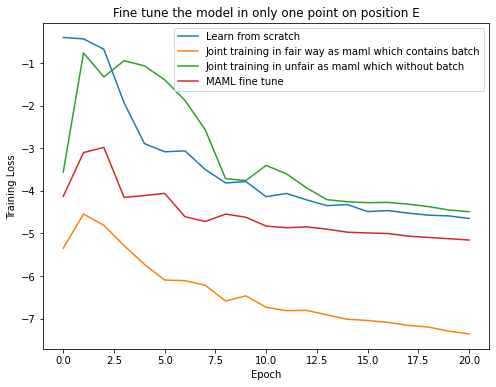

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(np.log(scratch_TrainingLoss))
plt.plot(np.log(joint_TrainingLoss))
plt.plot(np.log(joint_no_TrainingLoss))
plt.plot(np.log(maml_TrainingLoss))
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Fine tune the model in only one point on position E')
plt.legend(['Learn from scratch','Joint training in fair way as maml which contains batch','Joint training in unfair as maml which without batch','MAML fine tune'])
plt.savefig('all_train.jpg')
plt.show()


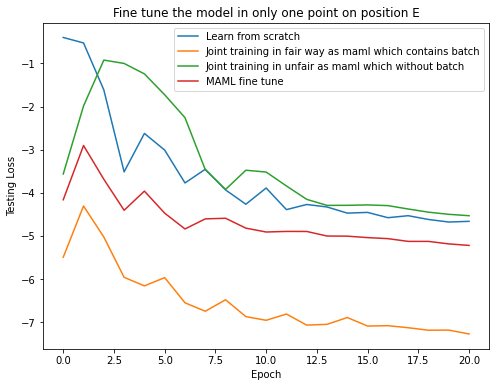

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(np.log(scratch_TestingLoss))
plt.plot(np.log(joint_TestingLoss))
plt.plot(np.log(joint_no_TestingLoss))
plt.plot(np.log(maml_TestingLoss))
plt.xlabel('Epoch')
plt.ylabel('Testing Loss')
plt.title('Fine tune the model in only one point on position E')
plt.legend(['Learn from scratch','Joint training in fair way as maml which contains batch','Joint training in unfair as maml which without batch','MAML fine tune'])
plt.savefig('all_test.jpg')
plt.show()


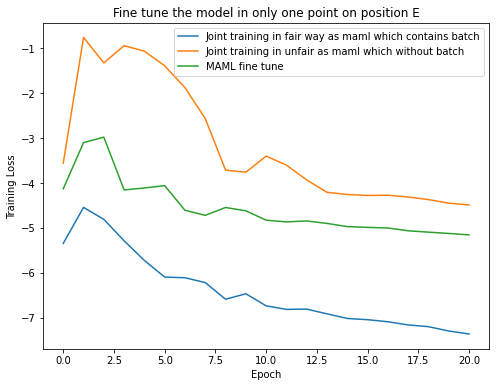

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(np.log(joint_TrainingLoss))
plt.plot(np.log(joint_no_TrainingLoss))
plt.plot(np.log(maml_TrainingLoss))
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Fine tune the model in only one point on position E')
plt.legend(['Joint training in fair way as maml which contains batch','Joint training in unfair as maml which without batch','MAML fine tune'])
plt.savefig('partial_train.jpg')
plt.show()


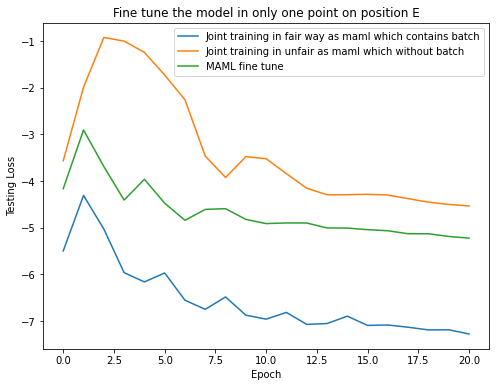

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(np.log(joint_TestingLoss))
plt.plot(np.log(joint_no_TestingLoss))
plt.plot(np.log(maml_TestingLoss))
plt.xlabel('Epoch')
plt.ylabel('Testing Loss')
plt.title('Fine tune the model in only one point on position E')
plt.legend(['Joint training in fair way as maml which contains batch','Joint training in unfair as maml which without batch','MAML fine tune'])
plt.savefig('partial_test.jpg')
plt.show()


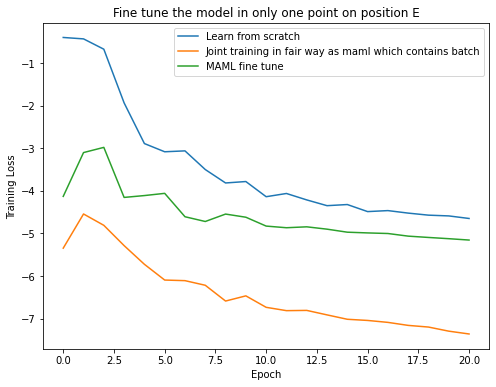

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(np.log(scratch_TrainingLoss))
plt.plot(np.log(joint_TrainingLoss))
plt.plot(np.log(maml_TrainingLoss))
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Fine tune the model in only one point on position E')
plt.legend(['Learn from scratch','Joint training in fair way as maml which contains batch','MAML fine tune'])
plt.savefig('partial_train_no_kr.jpg')
plt.show()


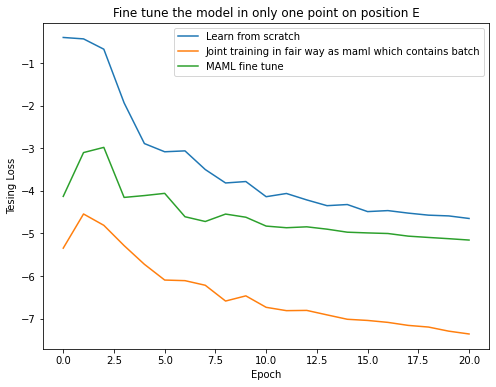

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(np.log(scratch_TrainingLoss))
plt.plot(np.log(joint_TrainingLoss))
plt.plot(np.log(maml_TrainingLoss))
plt.xlabel('Epoch')
plt.ylabel('Tesing Loss')
plt.title('Fine tune the model in only one point on position E')
plt.legend(['Learn from scratch','Joint training in fair way as maml which contains batch','MAML fine tune'])
plt.savefig('partial_test_no_kr.jpg')
plt.show()

## Fine tune on A

In [39]:
Joint_A_TrainingLoss = [0.004371932552506526, 0.012553357053548098, 0.006703253214557965, 0.004642238607630134, 0.003687892652427157, 0.002724283297235767, 0.002113914544073244, 0.0018699412855009239, 0.001658973633311689, 0.00134474392204235, 0.001208074720731626, 0.0010792597119385998, 0.0009111710630046824, 0.0008151049648101131, 0.0007507401169277728, 0.0006471841091600558, 0.0005948251540151736, 0.0005794132788044711, 0.0005211163952481002, 0.0004770221809546153, 0.00047223416428702575]
Joint_A_TestingLoss = [0.003997807390987873, 0.0074064829386770725, 0.0036034637596458197, 0.0034214798361063004, 0.002377828350290656, 0.002605780493468046, 0.0019541364163160324, 0.0014395819744095206, 0.0012971189571544528, 0.001385631156153977, 0.001044830889441073, 0.0009010711801238358, 0.0009117243462242186, 0.0007835346623323858, 0.0006849680212326348, 0.0006411623326130211, 0.0005595625843852758, 0.0005492775235325098, 0.0005294364527799189, 0.0004994921619072556, 0.0004061324580106884]

In [40]:
Joint_A_no_TrainingLoss = [0.018578972667455673, 0.02797836313645045, 0.015698339479664963, 0.010244546923786402, 0.008395494737972816, 0.008304604018727938, 0.006574452854692936, 0.006179340494175752, 0.0058157203408579035, 0.005108618177473545, 0.004824118223041296, 0.004585890875508388, 0.0042983172461390495, 0.004047021114577849, 0.0038170954988648496, 0.0036023009258011975, 0.003379100700840354, 0.003209633519873023, 0.0030137565918266773, 0.002811378100886941, 0.0026422378917535148]
Joint_A_no_TestingLoss = [0.018267922103405, 0.01956881396472454, 0.014790159650146961, 0.009686360135674477, 0.007902263663709164, 0.006227038335055113, 0.006663230713456869, 0.006020361091941595, 0.004910715389996767, 0.0048253461718559265, 0.004680604673922062, 0.0042600687593221664, 0.004002996254712343, 0.003857603296637535, 0.0036438999231904745, 0.003400414250791073, 0.0032017093617469072, 0.0030168741941452026, 0.002838065614923835, 0.0026622421573847532, 0.0025315796956419945]

In [41]:
MAML_A_TrainingLoss = [0.018346430112918217, 0.035817147543032966, 0.044395703822374344, 0.02026521290342013, 0.012600168896218141, 0.016762254138787586, 0.009014086176951727, 0.011159275658428669, 0.007434045895934105, 0.00891515084852775, 0.006519450185199578, 0.007283701406170924, 0.006025848599771659, 0.0064223829346398515, 0.005651171474407117, 0.005755753877262275, 0.0053448293668528395, 0.005331903075178464, 0.005056930705904961, 0.0049958859259883566, 0.004768103826791048]
MAML_A_TestingLoss = [0.017976144328713417, 0.06130386143922806, 0.010215950198471546, 0.014742420986294746, 0.016958460211753845, 0.010823470540344715, 0.011577886529266834, 0.0072909509763121605, 0.009385748766362667, 0.006698577664792538, 0.0075444746762514114, 0.006135621573776007, 0.006514360196888447, 0.005836221389472485, 0.005810128059238195, 0.005485010799020529, 0.005406727083027363, 0.005156402476131916, 0.005079107359051704, 0.004859528038650751, 0.004778257571160793]

In [42]:
scrath_A_TrainingLoss = [0.30545536677042645, 0.2937713364760081, 0.18836320439974466, 0.046612381003797054, 0.04308506970604261, 0.022390229006608326, 0.024552019623418648, 0.015400080010294914, 0.011819465706745783, 0.012181085844834646, 0.007718324661254883, 0.008793814728657404, 0.006628169057269891, 0.00680628651753068, 0.005836185999214649, 0.005579689672837655, 0.005485339400668939, 0.0049819254005948705, 0.004924254957586527, 0.00462572043761611, 0.004506151657551527]
scrath_A_TestingLoss = [0.3054550886154175, 0.25575780868530273, 0.03760135918855667, 0.032097842544317245, 0.03311610594391823, 0.03516574576497078, 0.011182148940861225, 0.016025487333536148, 0.010389208793640137, 0.00817849114537239, 0.009362288750708103, 0.006341320928186178, 0.00764479162171483, 0.005433194804936647, 0.005984820891171694, 0.005219925194978714, 0.0051237111911177635, 0.004943915642797947, 0.004545742645859718, 0.004610057920217514, 0.004295275080949068]

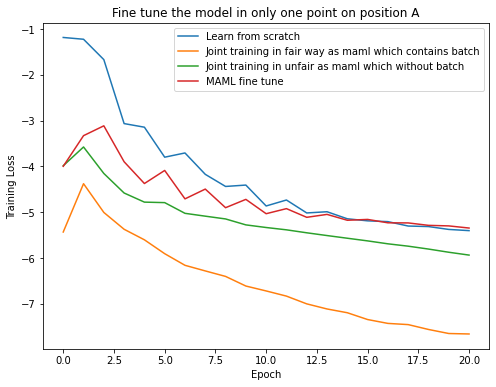

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(np.log(scrath_A_TrainingLoss))
plt.plot(np.log(Joint_A_TrainingLoss))
plt.plot(np.log(Joint_A_no_TrainingLoss))
plt.plot(np.log(MAML_A_TrainingLoss))
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Fine tune the model in only one point on position A')
plt.legend(['Learn from scratch','Joint training in fair way as maml which contains batch','Joint training in unfair as maml which without batch','MAML fine tune'])
plt.savefig('all_train_A.jpg')
plt.show()

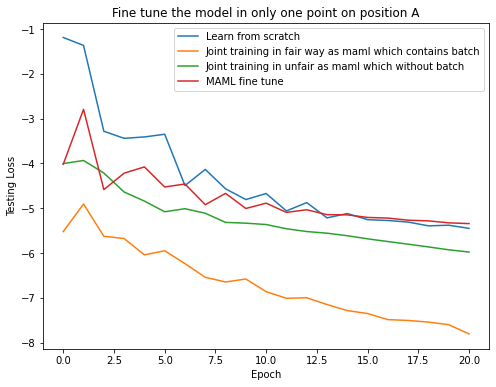

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(np.log(scrath_A_TestingLoss))
plt.plot(np.log(Joint_A_TestingLoss))
plt.plot(np.log(Joint_A_no_TestingLoss))
plt.plot(np.log(MAML_A_TestingLoss))
plt.xlabel('Epoch')
plt.ylabel('Testing Loss')
plt.title('Fine tune the model in only one point on position A')
plt.legend(['Learn from scratch','Joint training in fair way as maml which contains batch','Joint training in unfair as maml which without batch','MAML fine tune'])
plt.savefig('all_test_A.jpg')
plt.show()

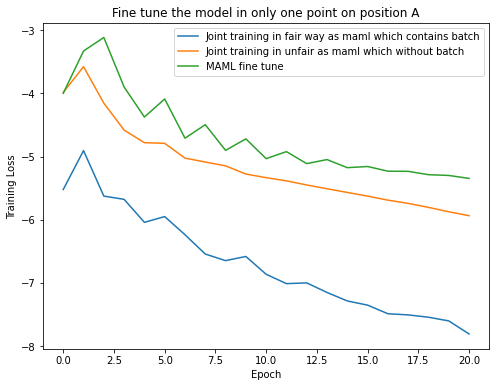

In [45]:
plt.figure(figsize=(8, 6))
plt.plot(np.log(Joint_A_TestingLoss))
plt.plot(np.log(Joint_A_no_TrainingLoss))
plt.plot(np.log(MAML_A_TrainingLoss))
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Fine tune the model in only one point on position A')
plt.legend(['Joint training in fair way as maml which contains batch','Joint training in unfair as maml which without batch','MAML fine tune'])
plt.savefig('partial_train_A.jpg')
plt.show()


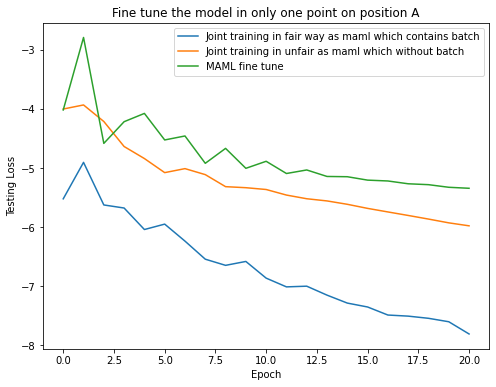

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(np.log(Joint_A_TestingLoss))
plt.plot(np.log(Joint_A_no_TestingLoss))
plt.plot(np.log(MAML_A_TestingLoss))
plt.xlabel('Epoch')
plt.ylabel('Testing Loss')
plt.title('Fine tune the model in only one point on position A')
plt.legend(['Joint training in fair way as maml which contains batch','Joint training in unfair as maml which without batch','MAML fine tune'])
plt.savefig('partial_test_A.jpg')
plt.show()


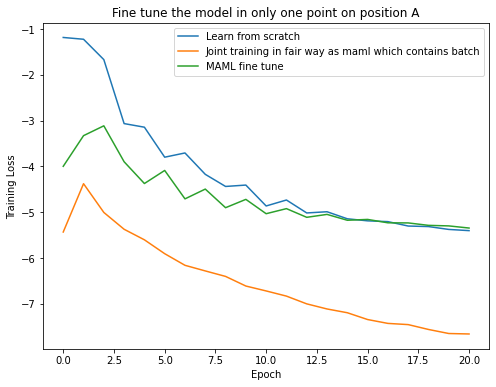

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(np.log(scrath_A_TrainingLoss))
plt.plot(np.log(Joint_A_TrainingLoss))
plt.plot(np.log(MAML_A_TrainingLoss))
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Fine tune the model in only one point on position A')
plt.legend(['Learn from scratch','Joint training in fair way as maml which contains batch','MAML fine tune'])
plt.savefig('partial_train_no_kr_A.jpg')
plt.show()

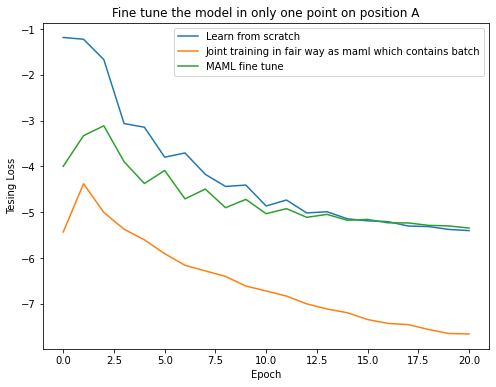

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(np.log(scrath_A_TrainingLoss))
plt.plot(np.log(Joint_A_TrainingLoss))
plt.plot(np.log(MAML_A_TrainingLoss))
plt.xlabel('Epoch')
plt.ylabel('Tesing Loss')
plt.title('Fine tune the model in only one point on position A')
plt.legend(['Learn from scratch','Joint training in fair way as maml which contains batch','MAML fine tune'])
plt.savefig('partial_test_no_kr_A.jpg')
plt.show()

## Traning loss

In [80]:
import json

In [49]:
filename = '/datadisk/sdc/wangruibo/Code_MAML_newframework/PyTorch-MAML-master/MAML_LOCATIONAL/New_dict_maml/maml_loss.txt'

In [50]:
with open(filename,'r') as f:
    data = f.read()

In [70]:
maml_loss = []
for i in data.split('\n'):
    maml_loss.append(float(i.split(':')[2].split(']')[0].strip()))

In [72]:
filename = '/datadisk/sdc/wangruibo/Code_MAML_newframework/PyTorch-MAML-master/MAML_LOCATIONAL/New_dict_joint/Joint_joint_one.txt'

In [73]:
with open(filename,'r') as f:
    data = f.read()

In [81]:
joint_loss = json.loads(data.split('\n')[1].split('=')[1].strip())

In [83]:
filename = '/datadisk/sdc/wangruibo/Code_MAML_newframework/PyTorch-MAML-master/MAML_LOCATIONAL/New_dict_joint_no_loop/Joint_joint_one.txt'

In [84]:
with open(filename,'r') as f:
    data = f.read()

In [85]:
joint_one_loss = json.loads(data.split('\n')[1].split('=')[1].strip())

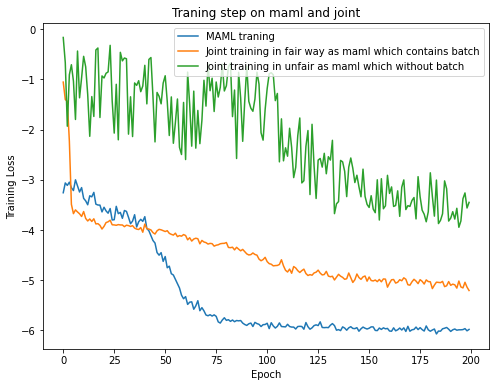

In [94]:
plt.figure(figsize=(8, 6))
plt.plot(np.log(maml_loss))
plt.plot(np.log(joint_loss))
plt.plot(np.log(joint_one_loss))
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Traning step on maml and joint')
plt.legend(['MAML traning','Joint training in fair way as maml which contains batch','Joint training in unfair as maml which without batch'])
plt.savefig('traninig_compare.jpg')
plt.show()